In [1]:
# imports
import logging
import sys, os
import time
from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh
from tf_pose.common import CocoPart
import matplotlib.pyplot as plt
import asyncio
import datetime
import random
import websockets
import nest_asyncio
import http.server
import socketserver
import threading
from IPython.display import IFrame
import base64
from PIL import Image
from io import BytesIO
import re
from utils import run_websocket_server, run_http_server
import tensorflow as tf
sys.path.insert(0, os.path.abspath('..'))


nest_asyncio.apply()

logger = logging.getLogger('TfPoseEstimatorRun')
logger.handlers.clear()
logger.setLevel(logging.ERROR)
ch = logging.StreamHandler()
ch.setLevel(logging.ERROR)
formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




In [2]:
# params 432, 368
w, h = 432, 368
image_path = './data/images/muscle_black1.jpg'
model = 'cmu'
resize_out_ratio = 2.0

In [3]:
e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))

[2019-12-27 18:30:11,431] [TfPoseEstimator] [INFO] loading graph from /home/ax/Programs/tf-pose-estimation/models/graph/cmu/graph_opt.pb(default size=432x368)
2019-12-27 18:30:11,431 INFO loading graph from /home/ax/Programs/tf-pose-estimation/models/graph/cmu/graph_opt.pb(default size=432x368)


2019-12-27 18:30:11,433 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/estimator.py:311: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



2019-12-27 18:30:11,434 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/estimator.py:312: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



2019-12-27 18:30:11,675 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/estimator.py:330: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



2019-12-27 18:30:12,000 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/estimator.py:332: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



2019-12-27 18:30:12,063 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/estimator.py:339: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



2019-12-27 18:30:12,064 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/estimator.py:340: The name tf.image.resize_area is deprecated. Please use tf.compat.v1.image.resize_area instead.



2019-12-27 18:30:12,070 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/tensblur/smoother.py:96: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2019-12-27 18:30:12,078 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/estimator.py:352: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2019-12-27 18:30:12,079 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/estimator.py:357: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



2019-12-27 18:30:12,080 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/estimator.py:358: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



2019-12-27 18:30:12,081 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/estimator.py:360: The name tf.report_uninitialized_variables is deprecated. Please use tf.compat.v1.report_uninitialized_variables instead.



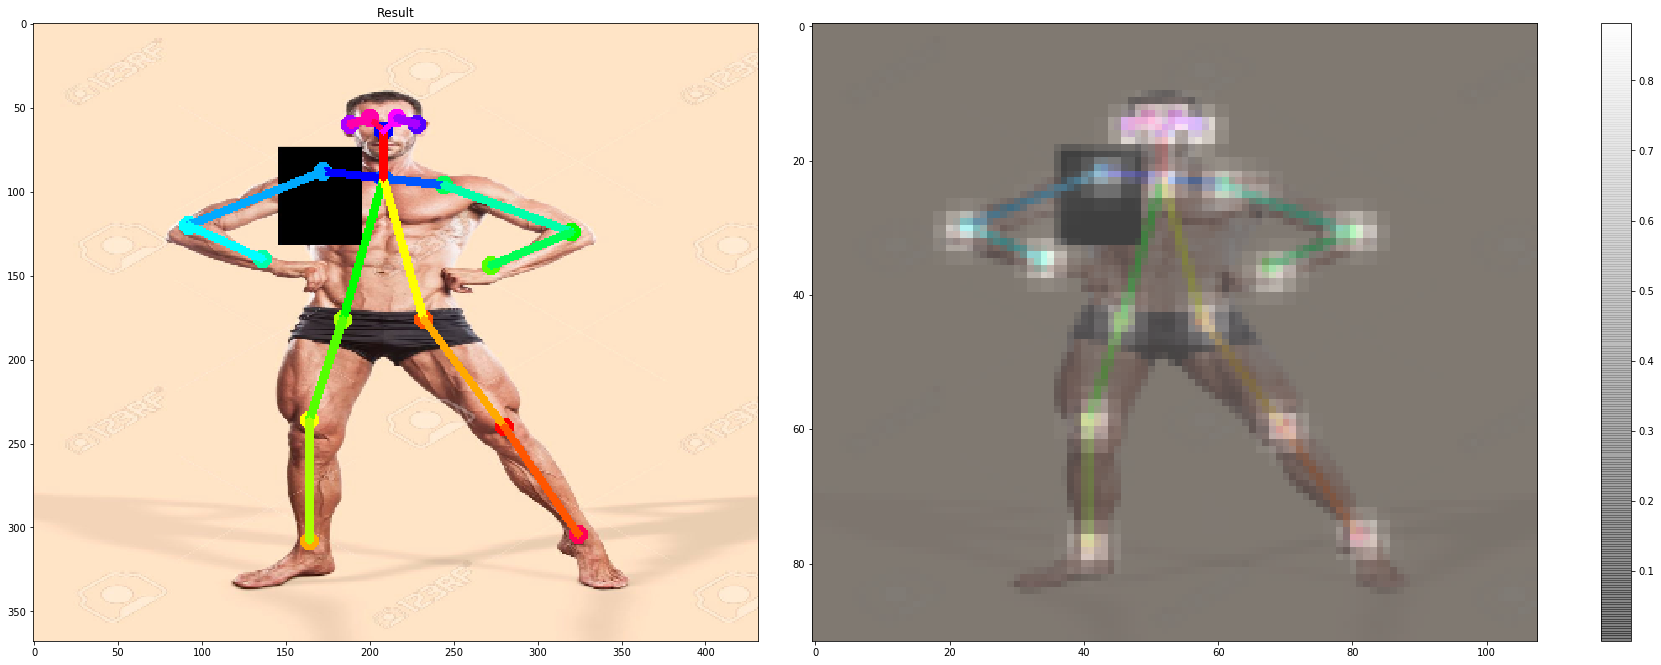

In [4]:
# estimate human poses from a single image !
image = common.read_imgfile(image_path, w, h)
humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
image_result = TfPoseEstimator.draw_humans(image, humans, imgcopy=True)

fig = plt.figure(figsize=(50, 25))
a = fig.add_subplot(2, 1, 1)
a.set_title('Result')
plt.imshow(cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB))

bgimg = cv2.cvtColor(image_result.astype(np.uint8), cv2.COLOR_BGR2RGB)
bgimg = cv2.resize(bgimg, (e.heatMat.shape[1], e.heatMat.shape[0]), interpolation=cv2.INTER_AREA)

# show network output
a = fig.add_subplot(2, 2, 2)
plt.imshow(bgimg, alpha=0.5)
tmp = np.amax(e.heatMat[:, :, :-1], axis=2)
plt.imshow(tmp, cmap=plt.cm.gray, alpha=0.5)
_ = plt.colorbar()

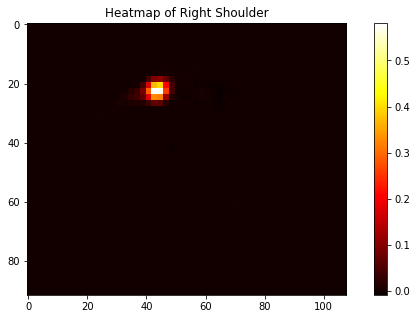

In [7]:
# show network output
fig = plt.figure(figsize=(10, 5))

# plt.imshow(bgimg, alpha=0.5)
heatmap = e.heatMat[:, :, CocoPart.RShoulder.value]
plt.imshow(heatmap, cmap=plt.cm.hot, alpha=1.0)
plt.title('Heatmap of Right Shoulder')
_ = plt.colorbar()

In [8]:
x, y = np.unravel_index(heatmap.argmax(), tmp.shape)
print(f'Max value {heatmap[x, y]} at ({x}, {y})')
print(np.sum(heatmap))
print(e.heatMat.shape, str(type(e.heatMat)))
print(e.pafMat.shape, str(type(e.pafMat)))

print(e.tensor_output.shape, str(type(e.tensor_output)))
print(e.tensor_image.shape, str(type(e.tensor_image)))

Max value 0.5812479853630066 at (22, 42)
19.660835
(92, 108, 19) <class 'numpy.ndarray'>
(92, 108, 38) <class 'numpy.ndarray'>
(?, ?, ?, 57) <class 'tensorflow.python.framework.ops.Tensor'>
(?, ?, ?, 3) <class 'tensorflow.python.framework.ops.Tensor'>


In [31]:
# Import DeepExplain
from deepexplain.tf.v1_x import DeepExplain

# get the current session
# sess = e.persistent_sess
tf.reset_default_graph()
sess = tf.Session()

# Since we will explain it, the model has to be wrapped in a DeepExplain context
with DeepExplain(session=sess, graph=sess.graph) as de:
    e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))
    input_tensor = e.tensor_image
    output_tensor = e.tensor_output[:, x, y, CocoPart.RShoulder.value]
    print(output_tensor.shape, str(type(output_tensor)))
    print(input_tensor.shape, str(type(input_tensor)))
    print(xs.shape, str(type(xs)))
    xs = tf.expand_dims(image, 0).eval(session=sess)

    attributions = {
        # Gradient-based
        # NOTE: reduce_max is used to select the output unit for the class predicted by the classifier
        # For an example of how to use the ground-truth labels instead, see mnist_cnn_keras notebook
        'Saliency maps':        de.explain('saliency', output_tensor, input_tensor, xs=xs),
        'Gradient * Input':     de.explain('grad*input', output_tensor, input_tensor, xs=xs),
        #'Integrated Gradients': de.explain('intgrad', T, X, xs),
        #'Epsilon-LRP':          de.explain('elrp', T, X, xs),
        #'DeepLIFT (Rescale)':   de.explain('deeplift', T, X, xs),
        # Perturbation-based (comment out to evaluate, but this will take a while!)
        # 'Occlusion [15x15]':    de.explain('occlusion', tf.reduce_max(logits, 1), X, xs, window_shape=(15,15,3), step=4)
    }
    
    # manuel gradient computation
    feed_dict = {}
    X = input_tensor
    feed_dict[X] = xs
    
    attr_methode = [tf.abs(g) for g in tf.gradients(ys=output_tensor, xs=X)]
    saliency = sess.run(attr_methode, feed_dict)

[2019-12-27 19:28:04,579] [TfPoseEstimator] [INFO] loading graph from /home/ax/Programs/tf-pose-estimation/models/graph/cmu/graph_opt.pb(default size=432x368)
2019-12-27 19:28:04,579 INFO loading graph from /home/ax/Programs/tf-pose-estimation/models/graph/cmu/graph_opt.pb(default size=432x368)
2019-12-27 19:28:12,795 INFO DeepExplain: running "saliency" explanation method (1)
2019-12-27 19:28:12,798 INFO Model with multiple inputs: False


(?,) <class 'tensorflow.python.framework.ops.Tensor'>
(?, ?, ?, 3) <class 'tensorflow.python.framework.ops.Tensor'>
(1, 368, 432, 3) <class 'numpy.ndarray'>
Runing explainer


2019-12-27 19:28:18,902 INFO DeepExplain: running "grad*input" explanation method (2)
2019-12-27 19:28:18,906 INFO Model with multiple inputs: False


Runing explainer


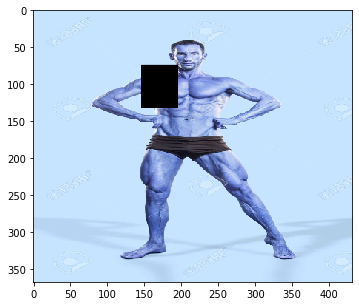

In [23]:
fig = plt.figure(figsize=(10, 5))
_ = plt.imshow(xs[0])

min = 0.0
max = 0.0
mean = 0.0
True


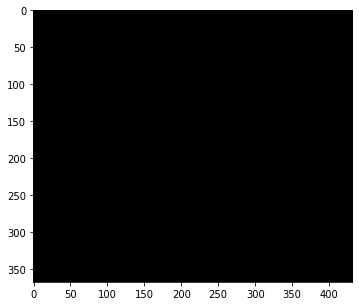

In [32]:
img_index = 0
attribution = saliency[0][img_index] # attributions['Saliency maps'][0]


SCALE = 10
fig = plt.figure(figsize=(10, 5))
_ = plt.imshow(attribution * SCALE, cmap=plt.cm.hot)
print(f'min = {np.min(attribution)}')
print(f'max = {np.max(attribution)}')
print(f'mean = {np.mean(attribution)}')
print(np.allclose(saliency[0][img_index], attributions['Saliency maps'][0]))